In [1]:
!pip install spectral
!pip install tensorflow

In [2]:
import os
import sys
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from scipy.io import loadmat
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras
import spectral
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import spectral
from tensorflow.keras import utils
init_notebook_mode(connected=True)
%matplotlib inline
#from test_utils import summary, comparator

In [3]:
dataset_folder = "Indian_pines_corrected.mat"
ground_truth_folder = "Indian_pines_gt.mat"
dataset_data = io.loadmat(dataset_folder)
ground_truth_data = io.loadmat(ground_truth_folder)
print("Keys in dataset_data:", dataset_data.keys())
print("Keys in ground_truth_data:", ground_truth_data.keys())

Keys in dataset_data: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Keys in ground_truth_data: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])


In [4]:
variable_name = 'indian_pines_corrected' #th the actual variable name
if variable_name in dataset_data:
    data = dataset_data[variable_name]
    print("Data shape:", data.shape)
    print("Data content:", data[1])
else:
    print(f"Variable '{variable_name}' not found in the .mat file.")

Data shape: (145, 145, 200)
Data content: [[2576 4388 4334 ... 1047 1030 1006]
 [2747 4264 4592 ... 1055 1039 1015]
 [2750 4268 4423 ... 1047 1026 1015]
 ...
 [3859 4512 4605 ... 1056 1035 1015]
 [3686 4264 4690 ... 1051 1012 1020]
 [2744 4268 4597 ... 1047 1019 1016]]


In [5]:
variable_name = 'indian_pines_gt' #th the actual variable name
if variable_name in ground_truth_data:
    data_gt = ground_truth_data[variable_name]
    print("Data shape:", data_gt.shape)
    print("Data content:", data_gt)
else:
    print(f"Variable '{variable_name}' not found in the .mat file.")

Data shape: (145, 145)
Data content: [[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

Best transfer learning models for CNN:

1. ResNet50

2. InceptionV3

3. DenseNet121

4. MobileNetV3

5. ShuffleNetV2

# Data Processing

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [8]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [9]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [10]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [11]:
test_ratio = 0.3
windowSize = 25

In [12]:
X, y = data, data_gt
X.shape, y.shape

((145, 145, 200), (145, 145))

In [13]:
K = X.shape[2]
K = 30
X,pca = applyPCA(X,numComponents=K)
X.shape

(145, 145, 30)

In [14]:
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [15]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7174, 25, 25, 30), (3075, 25, 25, 30), (7174,), (3075,))

# Models

In [25]:
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Add
from keras.initializers import glorot_uniform
from keras.models import Model

def identity_block(X, f, filters):
    """
    Implementation of the identity block as defined in ResNet50
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of the main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s=2):
    """
    Implementation of the convolutional block as defined in ResNet50
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of the main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of the main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of the main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape=(25, 25, 30), classes=16):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

#     X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
#     X = identity_block(X, 3, [512, 512, 2048])
#     X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D((2, 2))(X)
    X = Flatten()(X)

    dense_layer1 = Dense(units=256, activation='relu')(X)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=16, activation='softmax')(dense_layer2)

    model = Model(inputs=X_input, outputs=output_layer)
    return model

# Training

In [26]:
model = ResNet50(input_shape = (25, 25, 30), classes = 16)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25, 25, 30)]         0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 31, 31, 30)           0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_43 (Conv2D)          (None, 13, 13, 64)           94144     ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_43 (Ba  (None, 13, 13, 64)           256       ['conv2d_43[0][0]']     

                                                                                                  
 activation_47 (Activation)  (None, 6, 6, 64)             0         ['batch_normalization_51[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 6, 6, 64)             36928     ['activation_47[0][0]']       
                                                                                                  
 batch_normalization_52 (Ba  (None, 6, 6, 64)             256       ['conv2d_52[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_48 (Activation)  (None, 6, 6, 64)             0         ['batch_normalization_52[0][0]
          

 conv2d_61 (Conv2D)          (None, 3, 3, 128)            65664     ['activation_55[0][0]']       
                                                                                                  
 batch_normalization_61 (Ba  (None, 3, 3, 128)            512       ['conv2d_61[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_56 (Activation)  (None, 3, 3, 128)            0         ['batch_normalization_61[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_62 (Conv2D)          (None, 3, 3, 128)            147584    ['activation_56[0][0]']       
                                                                                                  
 batch_nor

                                                                    ']                            
                                                                                                  
 activation_64 (Activation)  (None, 2, 2, 1024)           0         ['add_20[0][0]']              
                                                                                                  
 conv2d_71 (Conv2D)          (None, 2, 2, 256)            262400    ['activation_64[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 2, 2, 256)            1024      ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_65 (Activation)  (None, 2, 2, 256)            0         ['batch_normalization_71[0][0]
          

 activation_73 (Activation)  (None, 2, 2, 1024)           0         ['add_23[0][0]']              
                                                                                                  
 conv2d_80 (Conv2D)          (None, 2, 2, 256)            262400    ['activation_73[0][0]']       
                                                                                                  
 batch_normalization_80 (Ba  (None, 2, 2, 256)            1024      ['conv2d_80[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_74 (Activation)  (None, 2, 2, 256)            0         ['batch_normalization_80[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_81

In [18]:
print ("number of training examples = " + str(Xtrain.shape[0]))
print ("number of test examples = " + str(Xtest.shape[0]))
print ("X_train shape: " + str(Xtrain.shape))
print ("Y_train shape: " + str(ytrain.shape))
print ("X_test shape: " + str(Xtest.shape))
print ("Y_test shape: " + str(ytest.shape))

number of training examples = 7174
number of test examples = 3075
X_train shape: (7174, 25, 25, 30)
Y_train shape: (7174,)
X_test shape: (3075, 25, 25, 30)
Y_test shape: (3075,)


In [27]:
from tensorflow.keras.utils import to_categorical
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Y_train_encoded = to_categorical(ytrain, num_classes=16)
Y_test_encoded = to_categorical(ytest, num_classes=16)

model.fit(Xtrain, Y_train_encoded, epochs = 100, batch_size = 32)

Epoch 1/100
225/225 [==============================] - 51s 170ms/step - loss: 2.0519 - accuracy: 0.4162
Epoch 2/100
225/225 [==============================] - 38s 168ms/step - loss: 1.0382 - accuracy: 0.6899
Epoch 3/100
225/225 [==============================] - 37s 165ms/step - loss: 0.7351 - accuracy: 0.7858
Epoch 4/100
225/225 [==============================] - 37s 167ms/step - loss: 0.5905 - accuracy: 0.8267
Epoch 5/100
225/225 [==============================] - 38s 167ms/step - loss: 0.4752 - accuracy: 0.8655
Epoch 6/100
225/225 [==============================] - 37s 165ms/step - loss: 0.3801 - accuracy: 0.9066
Epoch 7/100
225/225 [==============================] - 38s 167ms/step - loss: 0.4235 - accuracy: 0.8861
Epoch 8/100
225/225 [==============================] - 37s 166ms/step - loss: 0.2439 - accuracy: 0.9325
Epoch 9/100
225/225 [==============================] - 39s 173ms/step - loss: 0.1856 - accuracy: 0.9516
Epoch 10/100
225/225 [==============================] - 38s 171m

225/225 [==============================] - 37s 163ms/step - loss: 0.0117 - accuracy: 0.9976
Epoch 80/100
225/225 [==============================] - 36s 162ms/step - loss: 0.0272 - accuracy: 0.9955
Epoch 81/100
225/225 [==============================] - 36s 162ms/step - loss: 0.0059 - accuracy: 0.9987
Epoch 82/100
225/225 [==============================] - 37s 163ms/step - loss: 0.0226 - accuracy: 0.9960
Epoch 83/100
225/225 [==============================] - 37s 163ms/step - loss: 0.0255 - accuracy: 0.9961
Epoch 84/100
225/225 [==============================] - 37s 163ms/step - loss: 0.0223 - accuracy: 0.9976
Epoch 85/100
225/225 [==============================] - 37s 164ms/step - loss: 0.0372 - accuracy: 0.9944
Epoch 86/100
225/225 [==============================] - 37s 166ms/step - loss: 0.0153 - accuracy: 0.9975
Epoch 87/100
225/225 [==============================] - 37s 166ms/step - loss: 0.0261 - accuracy: 0.9958
Epoch 88/100
225/225 [==============================] - 37s 165ms/st

In [28]:
model.save("best-model.hdf5")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.from_numpy(Xtrain).float(), torch.from_numpy(ytrain).long())
test_dataset = TensorDataset(torch.from_numpy(Xtest).float(), torch.from_numpy(ytest).long())


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = models.resnet50(pretrained=True)

num_classes = len(np.unique(ytrain))
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Finished Training")
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Validation

In [29]:
results = model.evaluate(Xtest, Y_test_encoded, batch_size=32)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

97/97 [==============================] - 5s 31ms/step - loss: 0.0160 - accuracy: 0.9967
Test loss: 0.016000257804989815
Test accuracy: 0.9967479705810547


In [30]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K)
print(Xtest.shape)
ytest = utils.to_categorical(ytest)
print(ytest.shape)

(3075, 25, 25, 30)
(3075, 16)


In [31]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

97/97 [==============================] - 4s 31ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00       428
           2       0.97      1.00      0.99       249
           3       1.00      1.00      1.00        71
           4       1.00      0.98      0.99       145
           5       1.00      1.00      1.00       219
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00       143
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00       292
          10       1.00      1.00      1.00       737
          11       1.00      1.00      1.00       178
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00       380
          14       1.00      0.96      0.98       116
          15       1.00      1.00      1.00        28

    accuracy              

In [32]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [33]:
def reports (Xtest,ytest):
    classification = classification_report(np.argmax(ytest, axis=1), y_pred_test, target_names=target_names)
    oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)
    confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)
    score = model.evaluate(Xtest, ytest, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [34]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

print(Test_loss, Test_accuracy, oa, each_acc, aa, kappa)
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

97/97 [==============================] - 3s 31ms/step - loss: 0.0160 - accuracy: 0.9967
1.6000257804989815 99.67479705810547 99.67479674796748 [100.          99.76635514 100.         100.          97.93103448
  99.543379   100.         100.         100.         100.
 100.         100.         100.         100.          95.68965517
 100.        ] 99.55815148692457 99.62911134596035


97/97 [==============================] - 5s 42ms/step


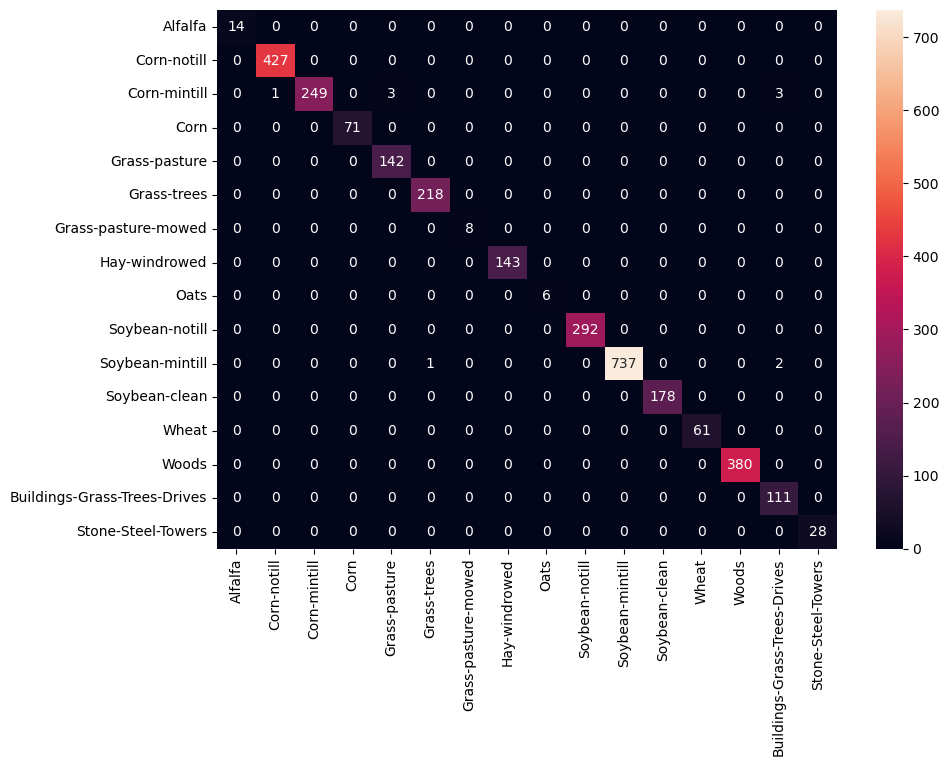

In [37]:
import seaborn as sns
plt.figure(figsize = (10,7))
pred = np.argmax(model.predict(Xtest), axis=1)
classes = target_names
mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(ytest, 1), 1))
df_cm = pd.DataFrame(mat, index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()